# **Spam Email Classification**

### 1. Importing Common Libraries

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import BytesIO
from zipfile import ZipFile
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import nltk
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report

### Download NLTK data

In [2]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### 2. Importing Dataset

In [3]:

KAGGLE_USERNAME = "medhatqeriaqous"
KAGGLE_KEY = "67498bfd82750a44fcce19e4468b0ec8"

def download_kaggle_dataset(dataset_url, save_path='.'):
    base_url = f"https://www.kaggle.com/api/v1/datasets/download/{dataset_url}"
    response = requests.get(base_url, auth=(KAGGLE_USERNAME, KAGGLE_KEY), stream=True)
    if response.status_code == 200:
        print("Download successful!")
        zip_path = os.path.join(save_path, 'dataset.zip')
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=128):
                f.write(chunk)
        with ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(save_path)
        print(f"Files extracted to {save_path}")
        return True
    else:
        print(f"Download failed with status code {response.status_code}")
        return False

dataset_url = "uciml/sms-spam-collection-dataset"
download_success = download_kaggle_dataset(dataset_url)

if download_success:
    try:
        df = pd.read_csv('spam.csv', encoding='latin-1')
        print("\nDataset loaded successfully!")
    except Exception as e:
        print(f"\nError loading dataset: {e}")
        try:
            df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label', 'message'])
            print("Dataset loaded from alternative file!")
        except Exception as e:
            print(f"Failed to load dataset: {e}")
            df = None
else:
    print("\nFailed to download dataset.")
    df = None


Download successful!
Files extracted to .

Dataset loaded successfully!


### 3. Preprocessing the Dataset

In [6]:
# Drop irrelevant columns
columns_to_drop = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
for col in columns_to_drop:
  if col in df.columns:
    df = df.drop(col, axis=1)

In [8]:
# Rename columns
df.columns = ['label', 'message']

In [9]:
# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
label      0
message    0
dtype: int64


In [10]:
# Convert label to binary (0 for ham, 1 for spam)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [11]:
# Text preprocessing function
def preprocess_text(text):
        text = text.lower()
        text = ''.join([char for char in text if char not in string.punctuation])
        words = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]
        return ' '.join(words)

In [12]:
 # Apply preprocessing
df['processed_message'] = df['message'].apply(preprocess_text)
print("\nProcessed data:")
print(df.head())



Processed data:
   label                                            message  \
0      0  Go until jurong point, crazy.. Available only ...   
1      0                      Ok lar... Joking wif u oni...   
2      1  Free entry in 2 a wkly comp to win FA Cup fina...   
3      0  U dun say so early hor... U c already then say...   
4      0  Nah I don't think he goes to usf, he lives aro...   

                                   processed_message  
0  go jurong point crazi avail bugi n great world...  
1                              ok lar joke wif u oni  
2  free entri 2 wkli comp win fa cup final tkt 21...  
3                u dun say earli hor u c alreadi say  
4          nah dont think goe usf live around though  


In [13]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_message']).toarray()
y = df['label'].values

In [14]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nTraining set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")


Training set shape: (4457, 5000)
Test set shape: (1115, 5000)


### 4. Visualizing Dataset

In [15]:
sns.set_style('whitegrid')

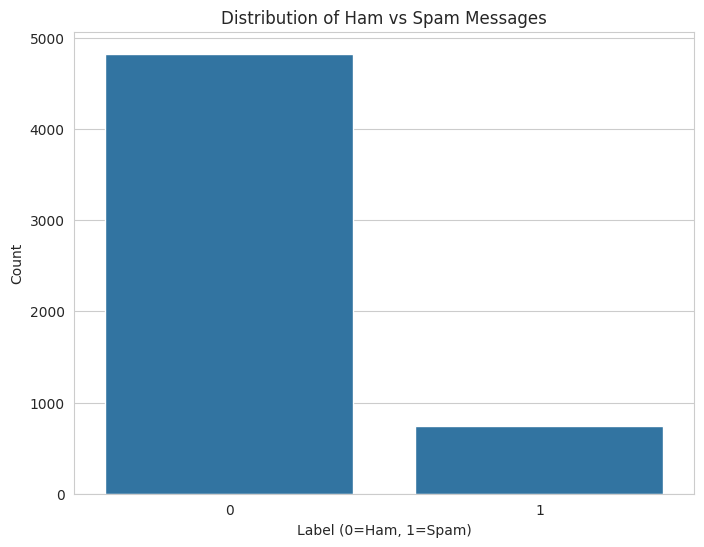

In [16]:
# Class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Ham vs Spam Messages')
plt.xlabel('Label (0=Ham, 1=Spam)')
plt.ylabel('Count')
plt.show()

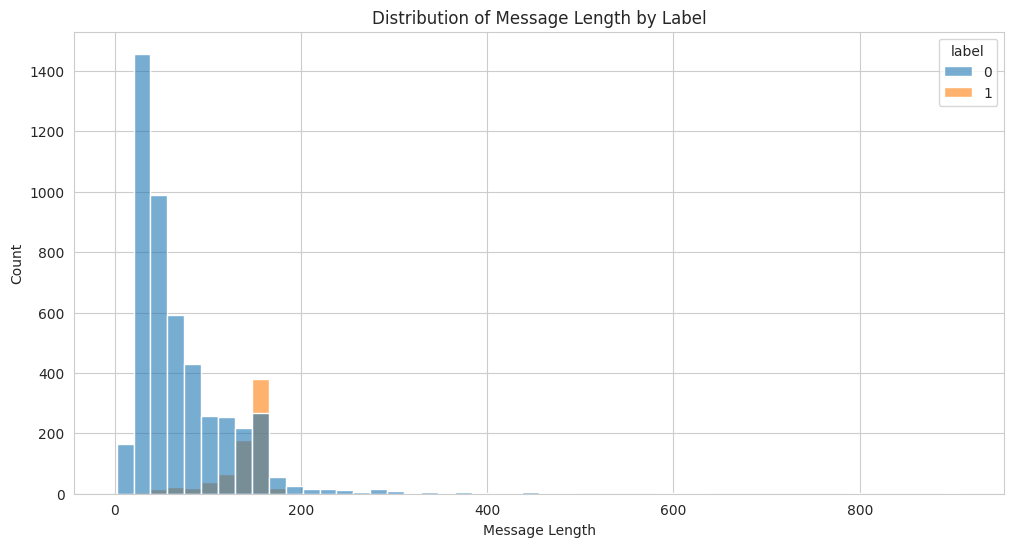

In [17]:
# Message length analysis
df['message_length'] = df['message'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='message_length', hue='label', bins=50, alpha=0.6)
plt.title('Distribution of Message Length by Label')
plt.xlabel('Message Length')
plt.ylabel('Count')
plt.show()

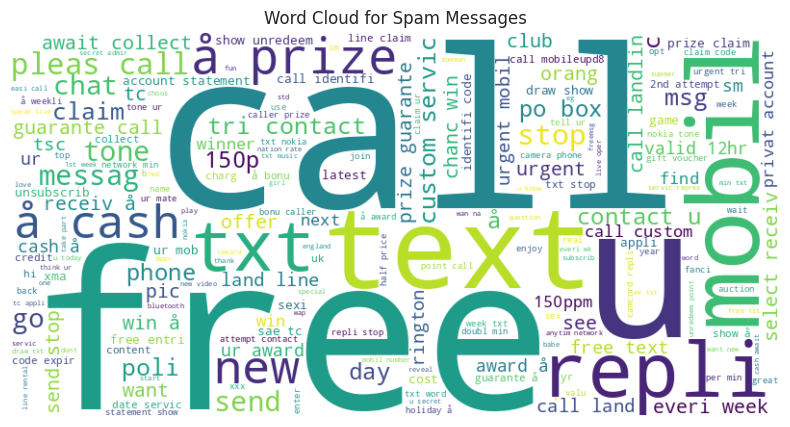

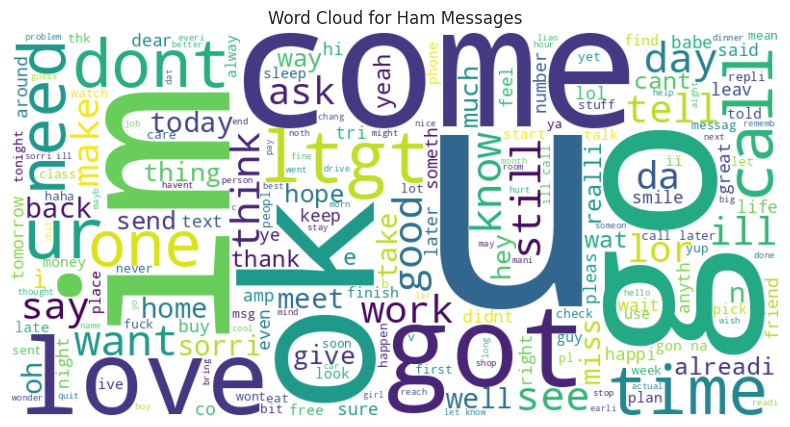

In [18]:
# Word clouds
def plot_word_cloud(text, title):
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title(title)
  plt.axis('off')
  plt.show()

spam_text = ' '.join(df[df['label'] == 1]['processed_message'])
plot_word_cloud(spam_text, 'Word Cloud for Spam Messages')

ham_text = ' '.join(df[df['label'] == 0]['processed_message'])
plot_word_cloud(ham_text, 'Word Cloud for Ham Messages')


### 5. Bagging

In [19]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [20]:
results = []

### Random Forest

In [21]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]

In [22]:
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.9758
AUC-ROC: 0.9831

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       0.99      0.83      0.90       149

    accuracy                           0.98      1115
   macro avg       0.98      0.91      0.94      1115
weighted avg       0.98      0.98      0.97      1115



In [23]:
results.append({
        'Model': 'Random Forest',
        'Accuracy': accuracy_score(y_test, y_pred_rf),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba_rf),
        'Precision (Spam)': precision_score(y_test, y_pred_rf),
        'Recall (Spam)': recall_score(y_test, y_pred_rf)
    })

### Bagged Decision Trees

In [24]:
base_estimator = DecisionTreeClassifier(max_depth=10)
bagging = BaggingClassifier(estimator=base_estimator, n_estimators=50, random_state=42)
bagging.fit(X_train, y_train)
y_pred_bag = bagging.predict(X_test)
y_pred_proba_bag = bagging.predict_proba(X_test)[:, 1]

In [25]:
print("\nBagged Decision Trees Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_bag):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_bag):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_bag))



Bagged Decision Trees Results:
Accuracy: 0.9507
AUC-ROC: 0.9594

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       966
           1       0.89      0.72      0.80       149

    accuracy                           0.95      1115
   macro avg       0.92      0.86      0.88      1115
weighted avg       0.95      0.95      0.95      1115



In [26]:
results.append({
        'Model': 'Bagged Decision Trees',
        'Accuracy': accuracy_score(y_test, y_pred_bag),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba_bag),
        'Precision (Spam)': precision_score(y_test, y_pred_bag),
        'Recall (Spam)': recall_score(y_test, y_pred_bag)
    })

### 6. Boosting

In [27]:
from xgboost import XGBClassifier

In [28]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, eval_metric="logloss")
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [29]:
print("\nXGBoost Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_xgb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))



XGBoost Results:
Accuracy: 0.9632
AUC-ROC: 0.9672

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       966
           1       0.99      0.73      0.84       149

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [30]:
results.append({
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'AUC-ROC': roc_auc_score(y_test, y_pred_proba_xgb),
        'Precision (Spam)': precision_score(y_test, y_pred_xgb),
        'Recall (Spam)': recall_score(y_test, y_pred_xgb)
    })

### 7. Stacking

In [31]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

In [35]:
base_learners = [
    ('nb', MultinomialNB()),
    ('svc', SVC(probability=True, kernel='linear')),
]

meta_learner = LogisticRegression()
stacking = StackingClassifier(estimators=base_learners, final_estimator=meta_learner, cv=5)
stacking.fit(X_train, y_train)

y_pred_stack = stacking.predict(X_test)
y_pred_proba_stack = stacking.predict_proba(X_test)[:, 1]

In [36]:
  print("\nStacking Classifier Results:")
  print(f"Accuracy: {accuracy_score(y_test, y_pred_stack):.4f}")
  print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba_stack):.4f}")
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred_stack))



Stacking Classifier Results:
Accuracy: 0.9857
AUC-ROC: 0.9870

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.90      0.94       149

    accuracy                           0.99      1115
   macro avg       0.99      0.95      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [37]:
results.append({
    'Model': 'Stacking Classifier',
    'Accuracy': accuracy_score(y_test, y_pred_stack),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba_stack),
    'Precision (Spam)': precision_score(y_test, y_pred_stack),
    'Recall (Spam)': recall_score(y_test, y_pred_stack)
})

### 8. Graphs and Analysis

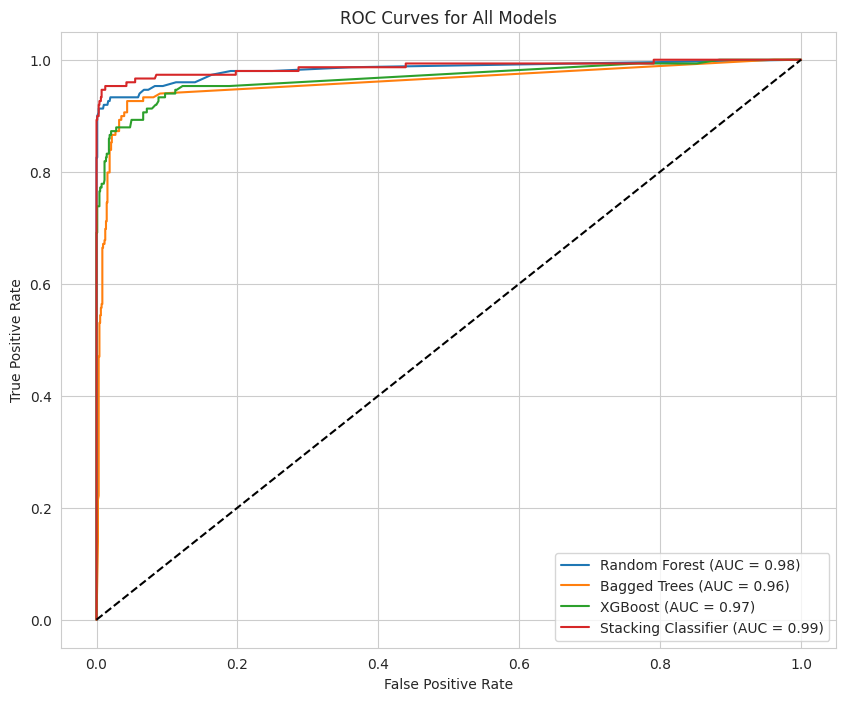

In [38]:
# ROC Curves
plt.figure(figsize=(10, 8))
def plot_roc_curve(y_true, y_pred_proba, label):
  fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
  plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_true, y_pred_proba):.2f})')

plot_roc_curve(y_test, y_pred_proba_rf, 'Random Forest')
plot_roc_curve(y_test, y_pred_proba_bag, 'Bagged Trees')
plot_roc_curve(y_test, y_pred_proba_xgb, 'XGBoost')
plot_roc_curve(y_test, y_pred_proba_stack, 'Stacking Classifier')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend()
plt.show()

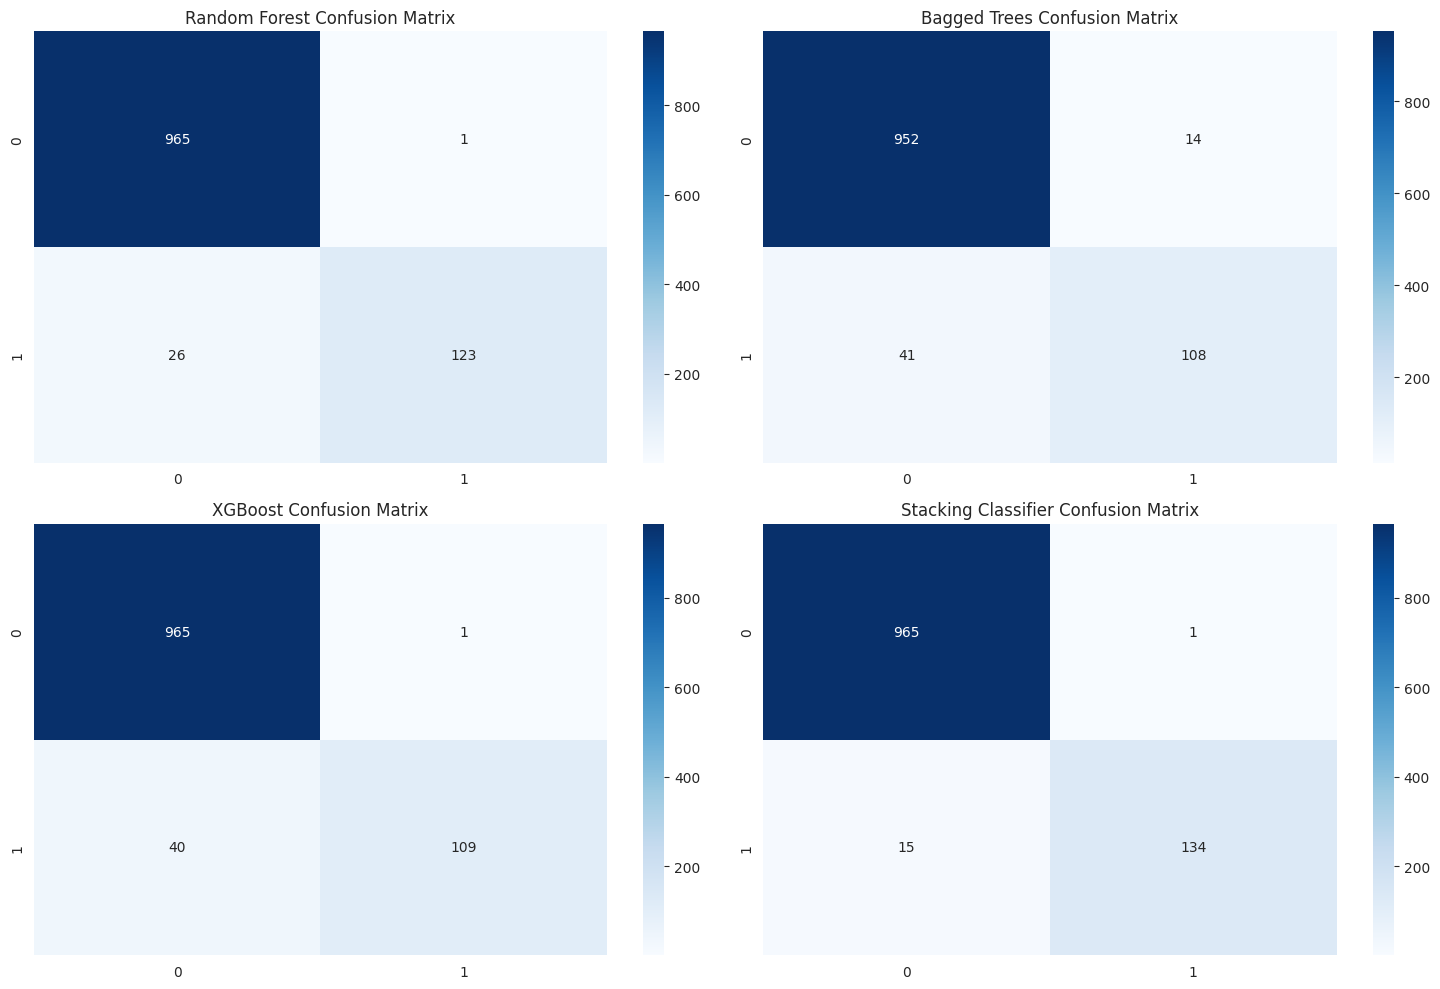

In [39]:
# Confusion Matrices
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')

plt.subplot(2, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_bag), annot=True, fmt='d', cmap='Blues')
plt.title('Bagged Trees Confusion Matrix')

plt.subplot(2, 2, 3)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')

plt.subplot(2, 2, 4)
sns.heatmap(confusion_matrix(y_test, y_pred_stack), annot=True, fmt='d', cmap='Blues')
plt.title('Stacking Classifier Confusion Matrix')

plt.tight_layout()
plt.show()

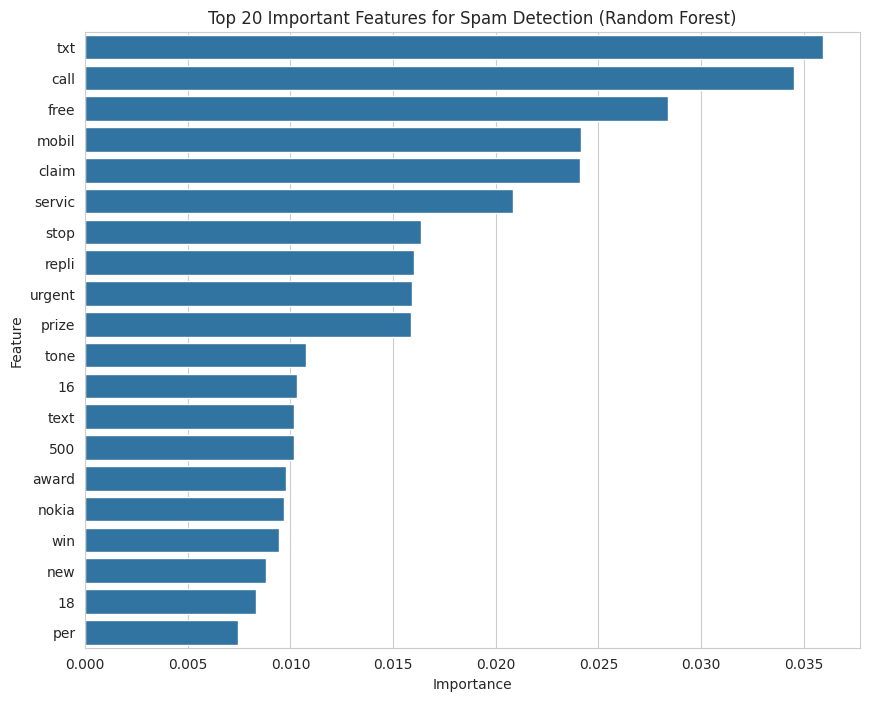

In [40]:
# Feature Importance for Random Forest
feature_importances = pd.DataFrame({'feature': tfidf.get_feature_names_out(), 'importance': rf.feature_importances_})
top_features = feature_importances.sort_values('importance', ascending=False).head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features)
plt.title('Top 20 Important Features for Spam Detection (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


Model Comparison:
                   Model  Accuracy   AUC-ROC  Precision (Spam)  Recall (Spam)
0          Random Forest  0.975785  0.983124          0.991935       0.825503
1  Bagged Decision Trees  0.950673  0.959433          0.885246       0.724832
2                XGBoost  0.963229  0.967172          0.990909       0.731544
3    Stacking Classifier  0.985650  0.986959          0.992593       0.899329


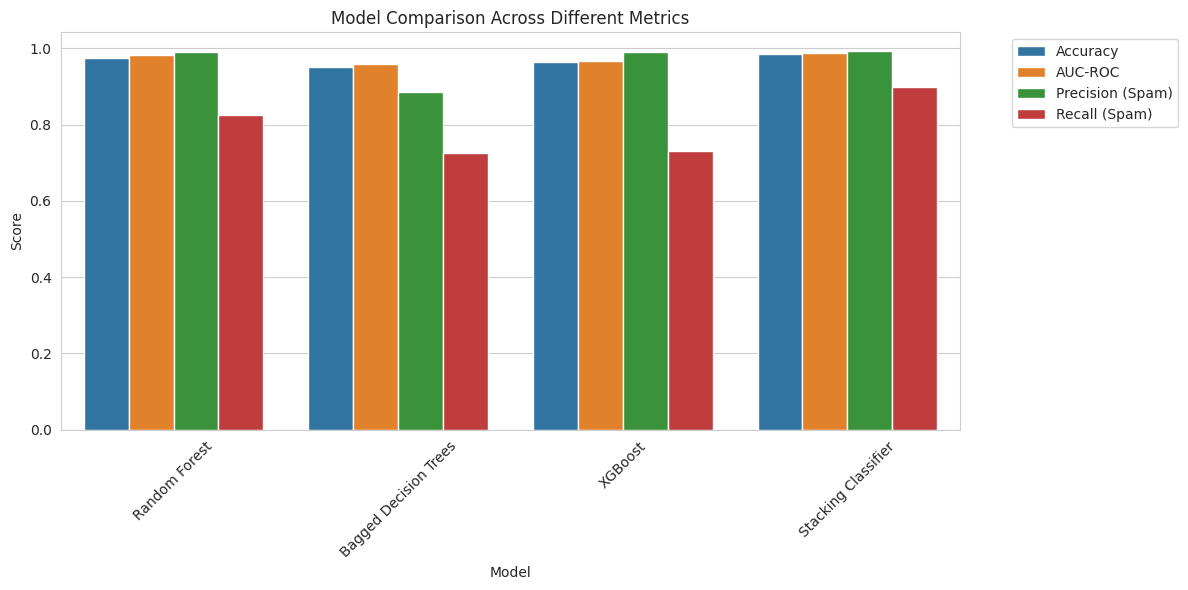

In [41]:
 # Model Comparison
results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

plt.figure(figsize=(12, 6))
results_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')
sns.barplot(x='Model', y='Score', hue='Metric', data=results_melted)
plt.title('Model Comparison Across Different Metrics')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()